

Use an image of an extended source generated externally. Import it, and scale it to a given integrated K-band magnitude. Observe it with a SCAO PSF for a 16mag on-axis guide star.

Using Halpha image of HCG04 from [Eigenthaler et al. 2015](http://adsabs.harvard.edu/abs/2015MNRAS.451.2793E), because it has fewer contaminating nearby objects.


Data for this example can be found here https://github.com/astronomyk/SimCADO/tree/master/docs/source/_static/images/HCG04_Halpha_fluxcalibrated.fits


In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

import numpy as np
from astropy.wcs import WCS
import astropy.units as u
from astropy.io import fits

import scopesim as sim
from scopesim.source.source_templates import Source
import scopesim_templates as sim_tp
from spextra import Spextrum


In [14]:
sp = Spextrum("brown/NGC0520").scale_to_magnitude(amplitude=22*u.ABmag, filter_curve="K").redshift(z=2)

hdu = fits.open("HCG04_Halpha_fluxcalibrated.fits")
original = hdu[0].data
galaxy_data = original[1100:1800,1100:1800]
cut = np.median(galaxy_data)
galaxy_data[galaxy_data<cut] = 0 
galaxy_data = galaxy_data / np.sum(galaxy_data)

# np.abs(galaxy_data) / np.sum(galaxy_data)
print(cut, np.sum(galaxy_data))

x_0 = galaxy_data.shape[0] 
y_0 = galaxy_data.shape[1] 
w, h = galaxy_data.shape
plate_scale = 0.002 * u.arcsec 


# creating header
header = fits.Header({"NAXIS": 2,
                          "NAXIS1": x_0 + 1,
                          "NAXIS2": y_0 + 1,
                          "CRPIX1": w // 2,
                          "CRPIX2": h // 2,
                          "CRVAL1": 0,
                          "CRVAL2": 0,
                          "CDELT1": -1*plate_scale.to(u.deg).value,
                          "CDELT2": plate_scale.to(u.deg).value,
                          "CUNIT1": "DEG",
                          "CUNIT2": "DEG",
                          "CTYPE1": 'RA---TAN',
                          "CTYPE2": 'DEC--TAN',
                          "SPEC_REF": 0})

new_hdu = fits.ImageHDU(data=galaxy_data, header=header)

# creating source
source = Source(image_hdu=new_hdu, spectra=[sp])



0.0018490122 1.0000001


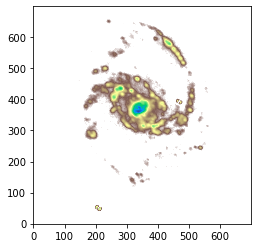

In [15]:
# plotting original data
plt.imshow(galaxy_data, norm=LogNorm(vmin=1e-6, vmax=1e-3), origin="lower", cmap="terrain_r")

In [16]:
sim.server.database.download_package(["locations/Armazones.zip",
                                      "telescopes/ELT.zip",
                                      "instruments/MAORY.zip",
                                      "instruments/MICADO.zip",] )

micado = sim.OpticalTrain("MICADO")


dit = 20
ndit = 20
micado.cmds["!OBS.dit"] = dit                        # dit & ndit
micado.cmds["!OBS.ndit"] = ndit
micado.cmds["!OBS.filter_name"] = "Ks"  # observing filter
micado["armazones_atmo_skycalc_ter_curve"].include = True
micado["armazones_atmo_default_ter_curve"].include = False

micado["detector_window"].include = True             # We observe a window to save time
micado['detector_linearity'].include = False         # Forget about non-linearity for a while

# Observe the source and save it to disk
micado.observe(source)

hdus = micado.readout(filename="distant_galaxy.fits")
print("Total exposure time %s seconds" % (dit*ndit))

Preparing 2 FieldOfViews
Total exposure time 400 seconds


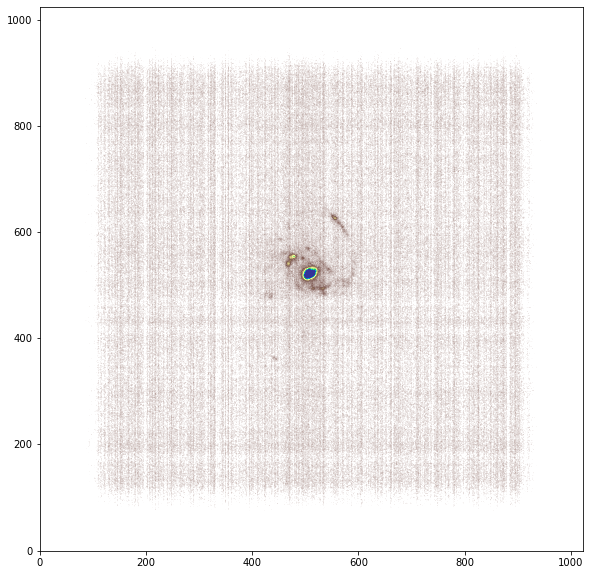

In [17]:
# Some ploting

plt.figure(figsize=(10,10))
data = hdus[0][1].data
data = data - np.median(data)
vmin = np.median(data)
vmax = vmin + 5*np.std(data)

plt.imshow(data, vmin=vmin, vmax=vmax, origin="lower", cmap="terrain_r")

element,name,class,included,z_orders
str21,str32,str31,bool,object
armazones,armazones_atmo_default_ter_curve,AtmosphericTERCurve,False,"[111, 511]"
armazones,armazones_atmo_dispersion,AtmosphericDispersion,False,[231]
armazones,armazones_atmo_skycalc_ter_curve,SkycalcTERCurve,True,"[112, 512]"
ELT,scope_surface_list,SurfaceList,True,"[20, 120, 520]"
ELT,scope_vibration,Vibration,True,"[244, 744]"
ELT,eso_combined_reflection,TERCurve,False,"[10, 110, 510]"
MICADO,micado_static_surfaces,SurfaceList,True,"[20, 120, 520]"
MICADO,filter_wheel_1,FilterWheel,True,"[124, 224, 524]"
MICADO,micado_ncpas_psf,NonCommonPathAberration,True,"[241, 641]"
